In [1]:
import os

import numpy as np
import pandas as pd
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE, chi2, SelectPercentile, SelectKBest, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector

# %matplotlib ipympl
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
# set some constants
RANDOM_STATE=42
TESTSIZE = 0.2
VALSIZE = 0.2
# number of features to select
NUMFEATURES = 5
# or a top percentile of features by importance to select
PERCFEATURES = 20
# name of the target columns
TARGET = 'CONDITION'

In [3]:
def load_datasets():
    datasets = dict()
    dataset_names = []
    for filename in os.listdir('data'):
        path = os.path.join('data', filename)
        dname, ext = filename.split('.')
        if dname in ['PHQ9_GAD7_df', 'PCL5_df']:
            sep=';'
        else:
            sep=','
        if ext == 'csv':
            datasets[dname] = pd.read_csv(path, sep=sep)
        elif ext == 'xlsx':
            datasets[dname] = pd.read_excel(path)
        dataset_names.append(dname)
        print(f"Loaded {filename} as {dname}")
    return datasets, dataset_names

In [4]:
# probably not used anymore but i spent too much time on this to delete it 
# also looks cool so idc

from itertools import combinations

def gen_interaction_combinations(
    col_names: list[str],
    max_order,
) -> list[tuple[str]]:
    """
    Generate all possible combinations of orders [1,...,max_order].\n
    Used to add interactions to the data.
    """
    res = []
    for order in range(1,max_order):
        res.append(list(combinations(col_names, order + 1)))
    return res

def calc_interaction(
    data: pd.DataFrame, 
    cols: list
) -> pd.Series:
    """ 
    Multiply specified columns of a dataframe.\n
    Returns a new series.
    """
    res = pd.Series(data=np.ones(data.shape[0]))
    for c in cols:
        res *= data[c]
    return res

def add_interactions(
    df: pd.DataFrame,
    col_names: list[str],
    max_order: int = 0
) -> pd.DataFrame:
    """
    Add all possible interactions between specified columns up to some order.\n
    """
    res = df.copy()

    assert max_order >= 0
    if max_order == 0:
        max_order = len(col_names)
        
    if max_order == 1:
        return res

    all_ints = gen_interaction_combinations(col_names=col_names, max_order=max_order)
    for ints_ord_i in all_ints:
        for inter in ints_ord_i:
            new_col = calc_interaction(df,inter)
            res['.'.join(map(str,inter))] = new_col
    return res

Preprocessing

In [5]:
def separate_target(data:np.ndarray, target_ind:int):
    return data[:,:target_ind], data[:,target_ind]

def check_split_integrity(
    data: pd.DataFrame,
    x_train: np.ndarray,
    x_val: np.ndarray, 
    x_test: np.ndarray,
    train_size: float = 1-VALSIZE-TESTSIZE, 
    val_size: float = VALSIZE, 
    test_size: float = TESTSIZE
    ):
    assert x_train.shape[1] == data.shape[1] - 1
    assert x_val.shape[1] == data.shape[1] - 1
    assert x_test.shape[1] == data.shape[1] - 1

    assert x_train.shape[0] + x_val.shape[0] + x_test.shape[0] == data.shape[0]
    assert abs(x_train.shape[0] - int(train_size*data.shape[0])) <= 1
    assert abs(x_val.shape[0] - int(val_size*data.shape[0])) <= 1
    assert abs(x_test.shape[0] - int(test_size*data.shape[0])) <= 1

    return

def preprocess(
    data: pd.DataFrame, 
    target_column: str,
    val_size: float=VALSIZE, 
    test_size: float=TESTSIZE, 
    random_state: float=RANDOM_STATE,
    scale: bool=False,
    center: bool=False
):
    """
    Function that combines all preprocessing steps.\n
    Returns the training, validation and test sets as numpy arrays.\n
    In our case, preserves column structure (doesn't necessarily in the general case though).\n
    """
    data_trainval, data_test = train_test_split(data, test_size=test_size,random_state=random_state, stratify=data[target_column])
    data_train, data_val = train_test_split(data_trainval, test_size=val_size/(1-test_size),random_state=random_state, stratify=data_trainval[target_column])
    predictors_pipeline = Pipeline(steps=[
        ('scale_numerics', StandardScaler(with_mean=center, with_std=scale))
    ])
    target_pipeline = Pipeline(steps=[
        ('encode_target', sklearn.preprocessing.OrdinalEncoder())
    ])
    preprocessor = ColumnTransformer([
        ('predictors', predictors_pipeline, data.columns[data.columns != target_column]),
        ('target', target_pipeline, [target_column])
    ], remainder='passthrough')

    data_train_pr = preprocessor.fit_transform(data_train)
    data_val_pr = preprocessor.transform(data_val)
    data_test_pr = preprocessor.transform(data_test)

    res = dict()
    target_index = data.columns.get_loc(target_column)
    res['train'] = separate_target(data_train_pr, target_index)
    res['val'] = separate_target(data_val_pr, target_index)
    res['test'] = separate_target(data_test_pr, target_index)

    return res

In [52]:
def draw_dataset_scores(scores, model_names, dname, fname):
    f = plt.figure(figsize=(15,5*len(model_names)), constrained_layout=True)
    #f.tight_layout(h_pad=5, w_pad=5)
    subfigs = f.subfigures(nrows=3, ncols=1)
    nmodels = len(model_names)
    for row, subfig in enumerate(subfigs):
        
        subfig.suptitle(f"Model: {model_names[row]}")

        ax = subfig.add_subplot(1, 2, 1)
        ax.plot(scores.columns.to_numpy(), scores.loc[row])
        ax.axhline(y=scores.loc[row][scores.columns[-1]], linestyle='dashed',linewidth=1, label='_nolegend_',c='orange')
        ax.set_ylabel('Accuracy')
        ax.grid()
        ax1 = ax.twiny()
        ax1.set_xlim(ax1.get_xlim())

        ax_d = subfig.add_subplot(1, 2, 2)
        ax_d.plot(scores.loc[row] - scores.loc[row][len(scores.columns)-1])
        ax_d.axhline(y=0, linestyle='dashed',linewidth=1, label='_nolegend_',c='orange')
        ax_d.grid()
        ax1_d = ax_d.twiny()
        ax1_d.set_xlim(ax1_d.get_xlim())

        if row == 0:
            ax1_d.set_xlabel("Proportion of components retained")
            ax1.set_xlabel("Proportion of components retained")
            ax_d.set_title('Difference between validation performance on' \
                    + '\n reduced and original data')
            ax.set_title('Validation performance')
        elif row == nmodels-1:
            ax_d.set_xlabel("N of components retained")
            ax.set_xlabel("N of components retained")

    # for p in percentile_locations:
    #     ax.axvline(x=p, linestyle='dashed', c='black', alpha=0.1, label='_nolegend_')
    # f.subplots_adjust(top=0.8)
    f.suptitle(f'Validation performance on {dname} reduced with {fname}', fontsize=15)
    return f

def draw_pca_results(pca):
    f, (ax,ax2) = plt.subplots(1,2, figsize=(15,5))
    ax.grid(axis='y', alpha=0.3)
    ax.bar(range(1, pca.explained_variance_ratio_.shape[-1] + 1), pca.explained_variance_ratio_, align='center',
        label='Individual explained variance')
    ax.set_ylim(bottom=0, top=1.05)
    ax1 = ax.twinx()
    ax1.set_ylim(ax.get_ylim())
    #ax1.set_ylim(bottom = pca.explained_variance_ratio_[0]/2.5, top = 1.0)
    ax1.step(range(1, pca.explained_variance_ratio_.shape[-1] + 1), np.cumsum(pca.explained_variance_ratio_), where='mid',
            label='Cumulative explained variance', color='red')
    ax.title.set_text('Explained variance ratio by component')
    ax.set_ylabel('Individual explained variance ratio')
    ax1.set_ylabel('Cumulative explained variance ratio')
    ax.set_xlabel('Principal component index')
    ax.set_xticks(ticks=range(1,pca.n_components_+1))

    ax2.plot(pca.explained_variance_)
    ax2.grid(axis='y', alpha=0.3)
    ax2.title.set_text('Scree Plot')
    ax2.set_xlabel('Eigenvalue index')
    ax2.set_ylabel('Eigenvalue')

    # f.legend(loc='center right')
    f.tight_layout()
    return f

def plot_feature_importances(X, y, feature_names_in, score_func=chi2):
    selector = SelectPercentile(score_func=score_func, percentile=PERCFEATURES)
    selector.fit(X, y)
    ax = plt.figure().add_subplot()
    ax.bar(feature_names_in, selector.scores_)
    ax.set_title(f'Feature importance with {score_func.__name__}')
    ax.set_ylabel('scores')
    ax.set_xlabel('features')
    ax.set_xticklabels(feature_names_in,rotation=45,ha='right')
    
    return ax

def plot_top_features(X, y, k, feature_names_in, score_func):

    assert np.shape(X)[0] == np.shape(y)[0]

    selector = SelectKBest(score_func=score_func, k=k)
    X_t = selector.fit_transform(X,y)
    fnames = selector.get_feature_names_out(input_features=feature_names_in)
    f = plt.figure(figsize=(10, 10))
    if k == 1:
        ax = f.add_subplot(projection='1d')
        ax.scatter(xs=X_t, c=['tab:orange' if cl == 1 else 'tab:blue' for cl in y],alpha=0.05)
        ax.set_xlabel(fnames[0])
    if k == 2:
        ax = f.add_subplot()
        ax.hist2d(x=X_t[:,0],y=X_t[:,1],bins=np.arange(1,6))
        ax.scatter(x=X_t[:,0],y=X_t[:,1], c=['tab:orange' if cl == 1 else 'tab:blue' for cl in y],alpha=0.05)
        ax.set_xlabel(fnames[0])
        ax.set_ylabel(fnames[1])
    if k == 3:
        f.tight_layout()
        ax3d = f.add_subplot(2,2,1, projection='3d')
        ax3d.scatter(xs=X_t[:,0],ys=X_t[:,1],zs=X_t[:,2], c=['tab:orange' if cl == 1 else 'tab:blue' for cl in y],alpha=0.1)
        ax3d.set_xlabel(fnames[0])
        ax3d.set_ylabel(fnames[1])
        ax3d.set_zlabel(fnames[2])
        ax3d.view_init(elev=28, azim=-47)
        
        ax = f.add_subplot(222)
        # ax.hist2d(x=X_t[:,0],y=X_t[:,1],bins=np.arange(1,6))
        ax.scatter(x=X_t[:,0],y=X_t[:,1], c=['tab:orange' if cl == 1 else 'tab:blue' for cl in y],alpha=0.05)
        ax.set_xlabel(fnames[0])
        ax.set_ylabel(fnames[1])

        ax = f.add_subplot(223)
        # ax.hist2d(x=X_t[:,0],y=X_t[:,2],bins=np.arange(1,6))
        ax.scatter(x=X_t[:,0],y=X_t[:,2], c=['tab:orange' if cl == 1 else 'tab:blue' for cl in y],alpha=0.05)
        ax.set_xlabel(fnames[0])
        ax.set_ylabel(fnames[2])

        ax = f.add_subplot(224)
        # ax.hist2d(x=X_t[:,1],y=X_t[:,2],bins=np.arange(1,6))
        ax.scatter(x=X_t[:,1],y=X_t[:,2], c=['tab:orange' if cl == 1 else 'tab:blue' for cl in y],alpha=0.05)
        ax.set_xlabel(fnames[1])
        ax.set_ylabel(fnames[2])

        f.subplots_adjust(left=0, right=1, top=1, bottom=0,hspace=0.5)


    # legend_props = [mpl.lines.Line2D([0],[0], marker='o',color='tab:orange'),
    #                 mpl.lines.Line2D([0],[0], marker='o',color='tab:blue')]
    # f.legend(legend_props, ['Honest','Dishonest'],bbox_to_anchor=(1,0.95))
    if score_func == chi2:
        title = 'Top 3 features by Chi2'
    elif score_func == mutual_info_classif:
        title = 'Top 3 features by Mutual Information Criterion'
    elif score_func == lasso_importance:
        title = 'Top 3 features by Logistic Lasso Coefficients'
    elif score_func == rf_importance:
        title = 'Top 3 features by Random Forest Importance'
    f.suptitle(title)

    return f

Custom importance functions

In [7]:
def lasso_importance(X_train, y_train):
    """Importance function that uses Lasso logistic regression coefficients for each feature as scores.\n
    Trained with cross-validation.\n"""
    lasso = sklearn.linear_model.LogisticRegressionCV(
        cv=5,
        random_state=RANDOM_STATE, 
        penalty='l1', 
        solver='liblinear',
        max_iter=1000
    ).fit(X_train, y_train)
    return np.abs(lasso.coef_[0])

def rf_importance(X_train, y_train):
    """Importance function that uses Random Forest coefficients for each feature as scores.\n
    Trained with cross-validation.\n"""
    rf = sklearn.ensemble.RandomForestClassifier(

    ).fit(X_train,y_train)
    return rf.feature_importances_


Experiment functions

In [8]:
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import GridSearchCV

def analyze_features(
    X_train, y_train, X_val, y_val,
    models,
    selection_func,
    scoring_func,
    percentiles: list = []
):
    n_features_in = X_train.shape[-1]
    scores = pd.DataFrame(columns=list(range(1,n_features_in + 1)),index=list(range(len(models))))
    feature_scores = selection_func(X_train, y_train)
    for i in range(len(models)):
        pipe = Pipeline([('reduction',SelectKBest(selection_func))('model',clone(models[i]))])
        grid = {
            'reduction__n_features': range(1, n_features_in + 1)
        }
        gridsearch = GridSearchCV(estimator=pipe, param_grid=grid, scoring=scoring_func)

    for n_features in range(1, n_features_in + 1):
        selector = SelectKBest(selection_func, k=n_features)
        selector.fit(X_train, y_train)
        X_train_red = selector.transform(X_train)
        X_val_red = selector.transform(X_val)
        for i in range(len(models)):
            model_reduced = clone(models[i])
            model_reduced.fit(X_train_red, y_train)
            score = scoring_func(y_true = y_val, y_pred=model_reduced.predict(X_val_red))
            #reduced_score = model_reduced.score(X_val_red, y_val)
            scores.loc[i][n_features] = score
    
    return scores, feature_scores


In [9]:
from sklearn.decomposition import PCA

scores_pca = dict()
def run_pca_exp(X_train, y_train, X_val, y_val, models, scoring_func):
    n_features_in = X_train.shape[-1]
    scores = pd.DataFrame(columns=list(range(1,n_features_in + 1)),index=list(range(len(models))))

    full_pca = PCA(n_components=n_features_in, random_state=RANDOM_STATE).fit(X_train)

    for n_features in range(1, n_features_in+1):
        pca = PCA(n_components = n_features, random_state=RANDOM_STATE)
        X_train_r = pca.fit_transform(X_train)
        X_val_r = pca.transform(X_val)
        for i in range(len(models)):
            model_reduced = clone(models[i])
            model_reduced.fit(X_train_r, y_train)
            score = scoring_func(y_true = y_val, y_pred=model_reduced.predict(X_val_r))
            scores.loc[i][n_features] = score
    return scores, full_pca

In [10]:
def eval_on_models(
    X_train, 
    y_train, 
    X_val, 
    y_val, 
    models: list,
    model_names: list[str],
    percentile=None,
    num_features=None,
    feature_names=None,
    feature_select_func=chi2,
):
    reduced_scores = pd.Series(index=model_names)
    if percentile is not None:
        selector = SelectPercentile(score_func=feature_select_func, percentile=percentile)
    elif num_features is not None:
        selector = SelectKBest(score_func=feature_select_func, k=num_features)
    else:
        raise Exception('Number of features not specified')
    selector.fit(X_train, y_train)
    features = selector.get_feature_names_out(input_features=feature_names)
    X_train_red = selector.transform(X_train)
    X_val_red = selector.transform(X_val)
    for (model,mname) in zip(models,model_names):
        model_reduced = clone(model)
        model_reduced.fit(X_train_red, y_train)
        reduced_score = model_reduced.score(X_val_red, y_val)
        reduced_scores.loc[mname] = reduced_score
    return reduced_scores, features


In [11]:
def eval_subsets(
    X_train, 
    y_train, 
    X_val, 
    y_val, 
    models: list,
    model_names: list[str],
    percentiles: list=[5, 10, 30, 50, 80, 100],
    num_features = [3],
    feature_select_func: callable=chi2
):  
    """
    Evaluate a range of models on a range of reduced features.\n
    Feature importances can be calculated with `feature_select_func`.
    """
    # full_scores = []
    reduced_scores = pd.DataFrame(columns=percentiles,index=model_names)
    features = dict()
    # for model in models:
    #     #model_reduced_scores = pd.DataFrame(index=['Model', 'Percentile'])
    #     model_full = clone(model)
    #     model_full.fit(X_train, y_train)
    #     full_score = model_full.score(X_val, y_val)
    #     full_scores.append(full_score)
    for (model,mname) in zip(models,model_names):
        model_reduced = clone(model)
        model_reduced_scores = dict()
        for percentile in percentiles:
            # reduce the set
            selector = SelectPercentile(score_func=feature_select_func, percentile=percentile)
            selector.fit(X_train, y_train)
            features[percentile] = selector.get_support(indices=True)
            X_train_red = selector.transform(X_train)
            X_val_red = selector.transform(X_val)
            model_reduced.fit(X_train_red, y_train)
            reduced_score = model_reduced.score(X_val_red, y_val)
            model_reduced_scores[percentile] = reduced_score
        reduced_scores.loc[mname] = model_reduced_scores
        #reduced_scores.append(model_reduced_scores)
    return pd.DataFrame(reduced_scores), features


In [12]:
def eval_for_all_datasets(
    datasets,
    models,
    model_names,
    percentiles = [5, 10, 30, 50, 80, 100],
    num_features = 3,
    feature_select_func=chi2
):
    """
    Wrapper function that applies `eval_subsets` to several datasets and gives the result in a neat dataframe.
    """

    scores = pd.DataFrame(index=pd.MultiIndex.from_product([dataset_names, model_names]), columns=percentiles)
    features = dict()
    features_simp = dict()
    for dname in datasets.keys():
        dataset = datasets[dname]
        train, val, test = preprocess(dataset, TARGET)
        target_col_ind = dataset.columns.get_loc(TARGET)
        X_train, y_train = separate_target(train,target_col_ind)
        X_val, y_val = separate_target(val,target_col_ind)
        X_test, _ = separate_target(test,target_col_ind)
        check_split_integrity(dataset, X_train, X_val, X_test)
        feature_names = dataset.columns[dataset.columns != TARGET]
        feature_names = None
        dataset_scores, dataset_features = eval_subsets(
            X_train, y_train, X_val, y_val, models, model_names=model_names, percentiles=percentiles, feature_select_func=feature_select_func
        )
        scores.loc[dname] = np.array(dataset_scores)
        features[dname] = dataset_features
    return scores, pd.DataFrame(features)


Load datasets

In [13]:
datasets, dataset_names = load_datasets()

Loaded BF_df_CTU.csv as BF_df_CTU
Loaded BF_df_OU.csv as BF_df_OU
Loaded BF_df_V.csv as BF_df_V
Loaded IADQ_df.csv as IADQ_df
Loaded IESR_df.csv as IESR_df
Loaded PCL5_df.csv as PCL5_df
Loaded PHQ9_GAD7_df.csv as PHQ9_GAD7_df
Loaded PRMQ_df.csv as PRMQ_df
Loaded RAW_DDDT.CSV as RAW_DDDT


Exploration (IADQ dataset)

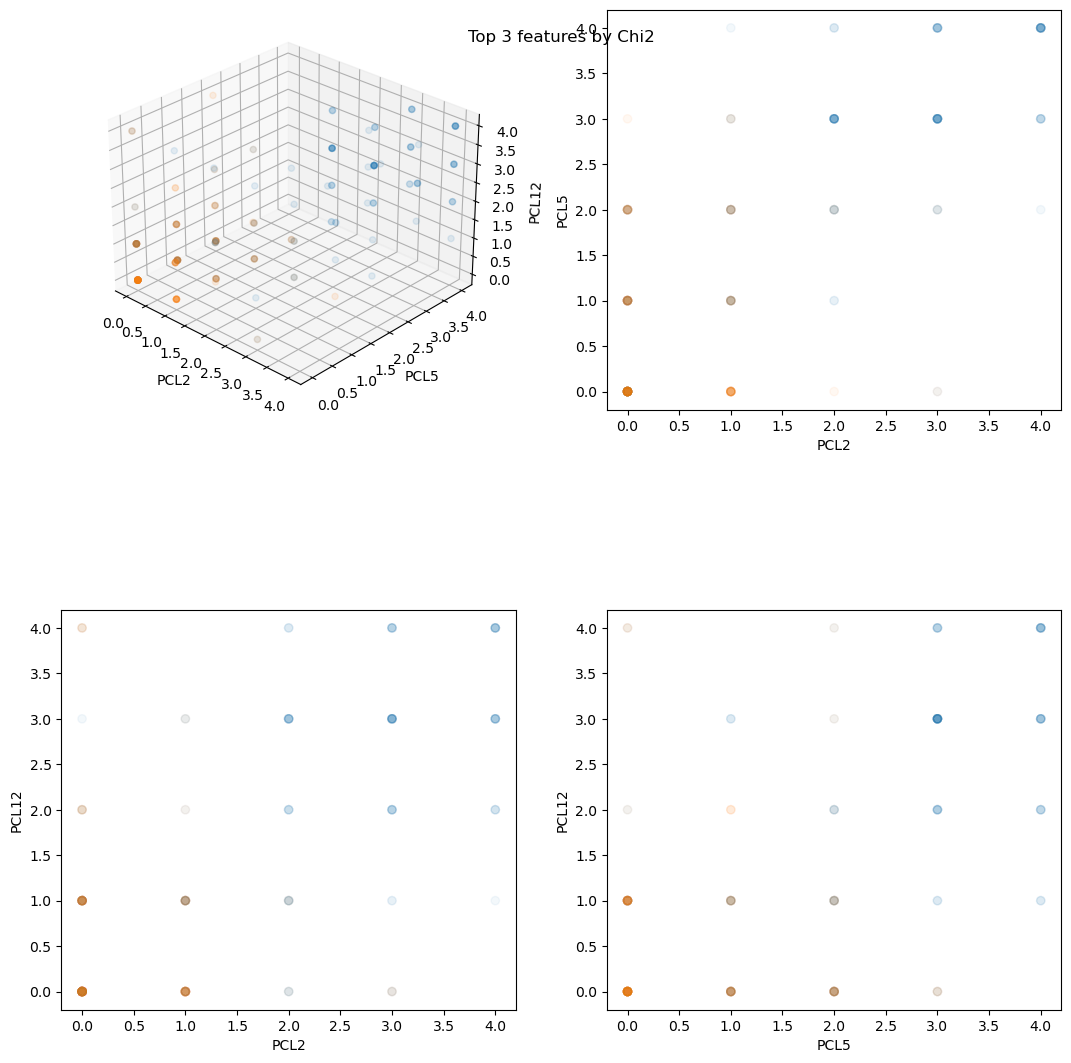

In [14]:
pcl = preprocess(datasets['PCL5_df'], TARGET)

# df_train = pd.DataFrame(iadq['train'][0], columns=rawdata.columns)
f = plot_top_features(pcl['train'][0], pcl['train'][1], 3, datasets['PCL5_df'].columns[:-1],score_func=chi2)

Feature selection experiments

In [15]:
models = [
    sklearn.svm.SVC(kernel='linear', random_state=RANDOM_STATE),
    RandomForestClassifier(random_state=RANDOM_STATE),
    sklearn.linear_model.LogisticRegression(random_state=RANDOM_STATE)
]
model_names = [
    'SVC',
    'Random Forest',
    'Logistic Regression'
]
fs_funcs = {'chi2': chi2, 'mi': mutual_info_classif, 'lasso': lasso_importance, 'forest': rf_importance}

In [ ]:
experiment_pipeline = Pipeline([('select features', ),('')])

In [16]:
datasets.keys()

dict_keys(['BF_df_CTU', 'BF_df_OU', 'BF_df_V', 'IADQ_df', 'IESR_df', 'PCL5_df', 'PHQ9_GAD7_df', 'PRMQ_df'])

In [17]:
scores_chi2 = dict()
importance_chi2 = dict()
scores_mi = dict()
importance_mi = dict()
scores_lasso = dict()
importance_lasso = dict()
scores_rf = dict()
importance_rf = dict()
for dname in list(datasets.keys()):
    d = preprocess(datasets[dname], TARGET)

    scores_chi2[dname], importance_chi2[dname] = analyze_features(d['train'][0], d['train'][1], d['val'][0], d['val'][1], models, selection_func=chi2, scoring_func=accuracy_score)
    scores_mi[dname], importance_mi[dname] = analyze_features(d['train'][0], d['train'][1], d['val'][0], d['val'][1], models, selection_func=mutual_info_classif, scoring_func=accuracy_score)
    scores_lasso[dname], importance_lasso[dname] = analyze_features(d['train'][0], d['train'][1], d['val'][0], d['val'][1], models, selection_func=lasso_importance, scoring_func=accuracy_score)
    scores_rf[dname], importance_rf[dname] = analyze_features(d['train'][0], d['train'][1], d['val'][0], d['val'][1], models, selection_func=rf_importance, scoring_func=accuracy_score)



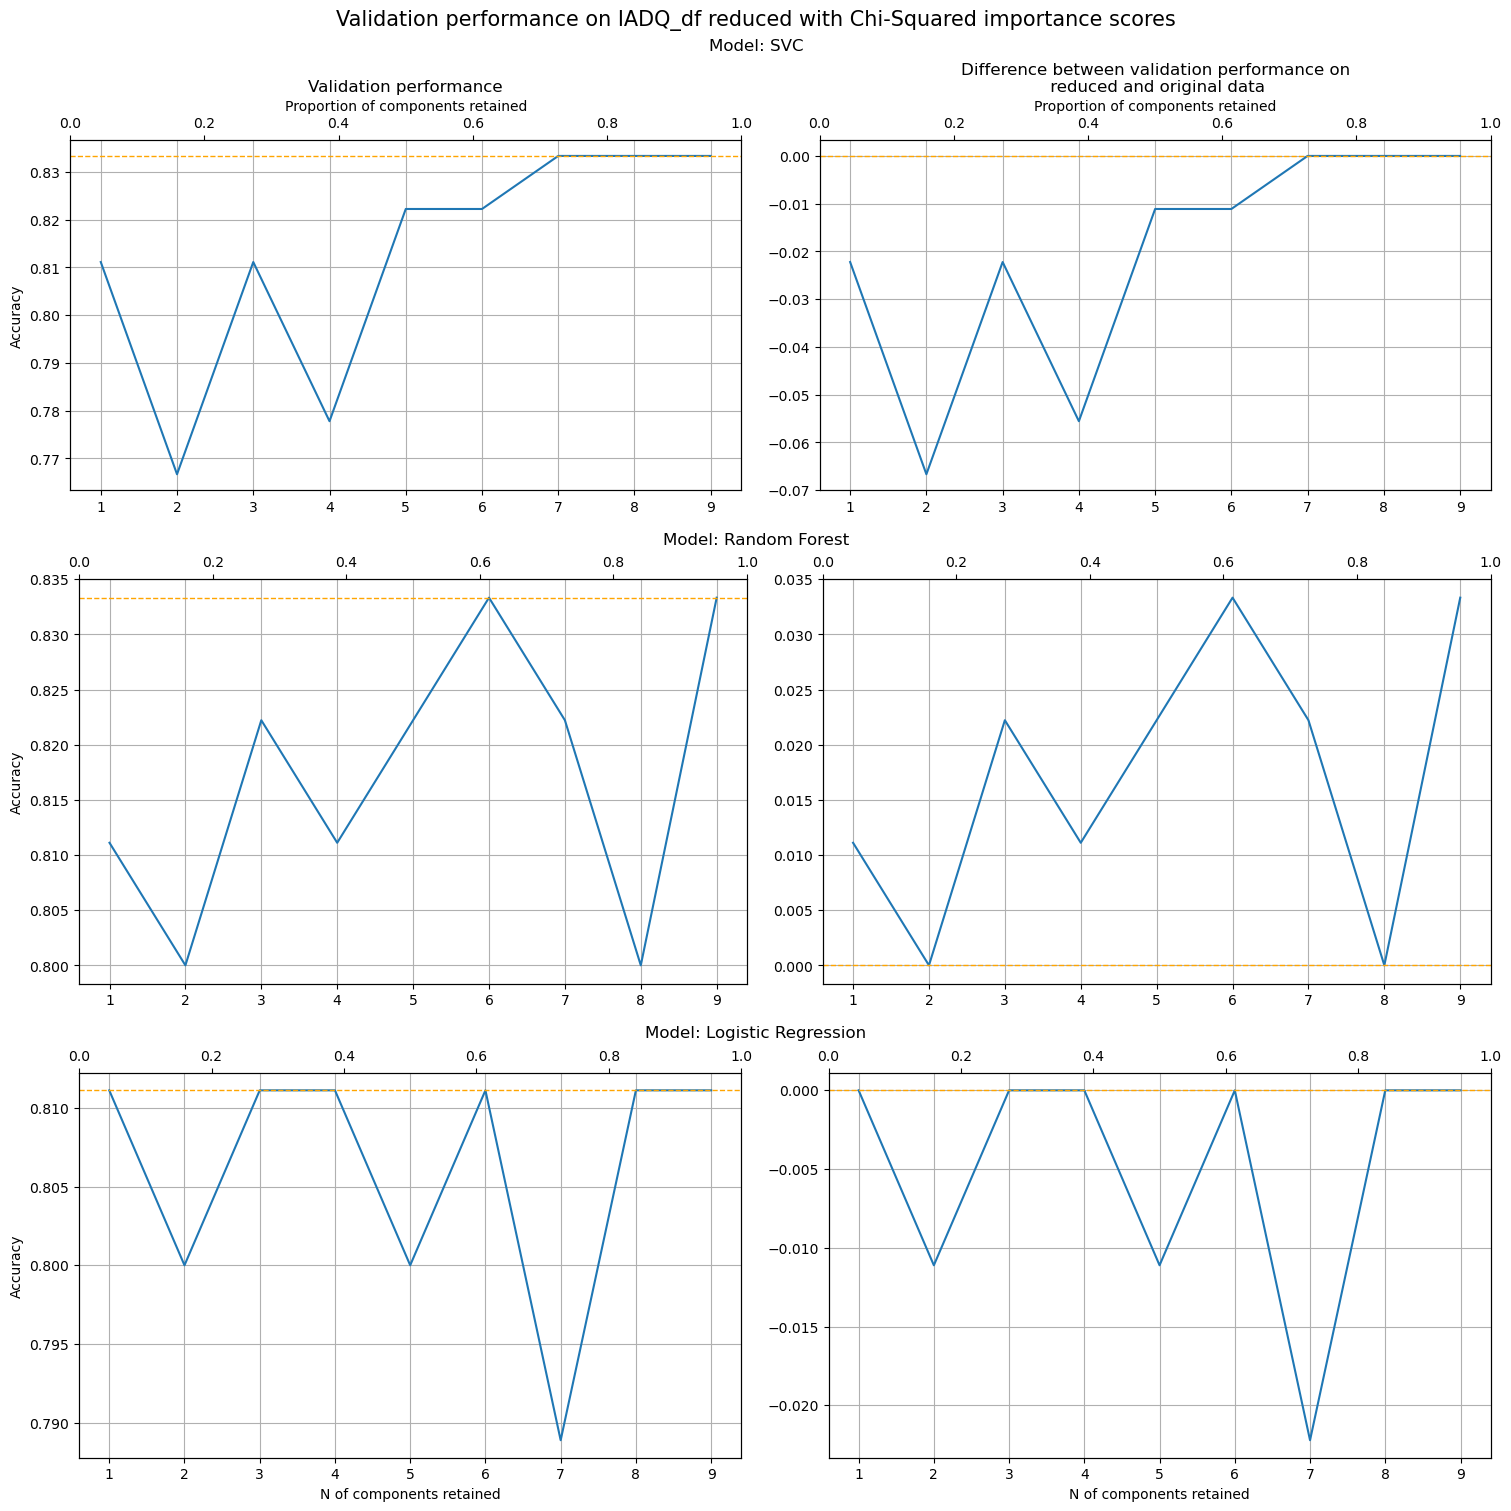

In [129]:
# Can visualize any of the results

dname = 'IADQ_df'
fname = 'Chi-Squared importance scores'
f = draw_dataset_scores(scores_chi2[dname], model_names, dname, fname)
# f.savefig(fname=f'{dname}_{fname}_perf')

PCA + Factor Analysis

In [19]:
from sklearn.decomposition import PCA, SparsePCA

def calc_pca_stats(X_train, X_val, n_comp=None):
    pca = PCA(n_components=n_comp)
    X_train_r = pca.fit_transform(X_train)
    X_val_r = pca.transform(X_val)
    cum_exp_var_ratio = np.cumsum(pca.explained_variance_ratio_)
    
    return pca, X_train_r, X_val_r, cum_exp_var_ratio

In [20]:
scores_pca = dict()
decomp = dict()
for dname in datasets.keys():
    ds = preprocess(datasets[dname], TARGET)
    scores_pca[dname], decomp[dname] = run_pca_exp(ds['train'][0], ds['train'][1], ds['val'][0], ds['val'][1], models, accuracy_score)

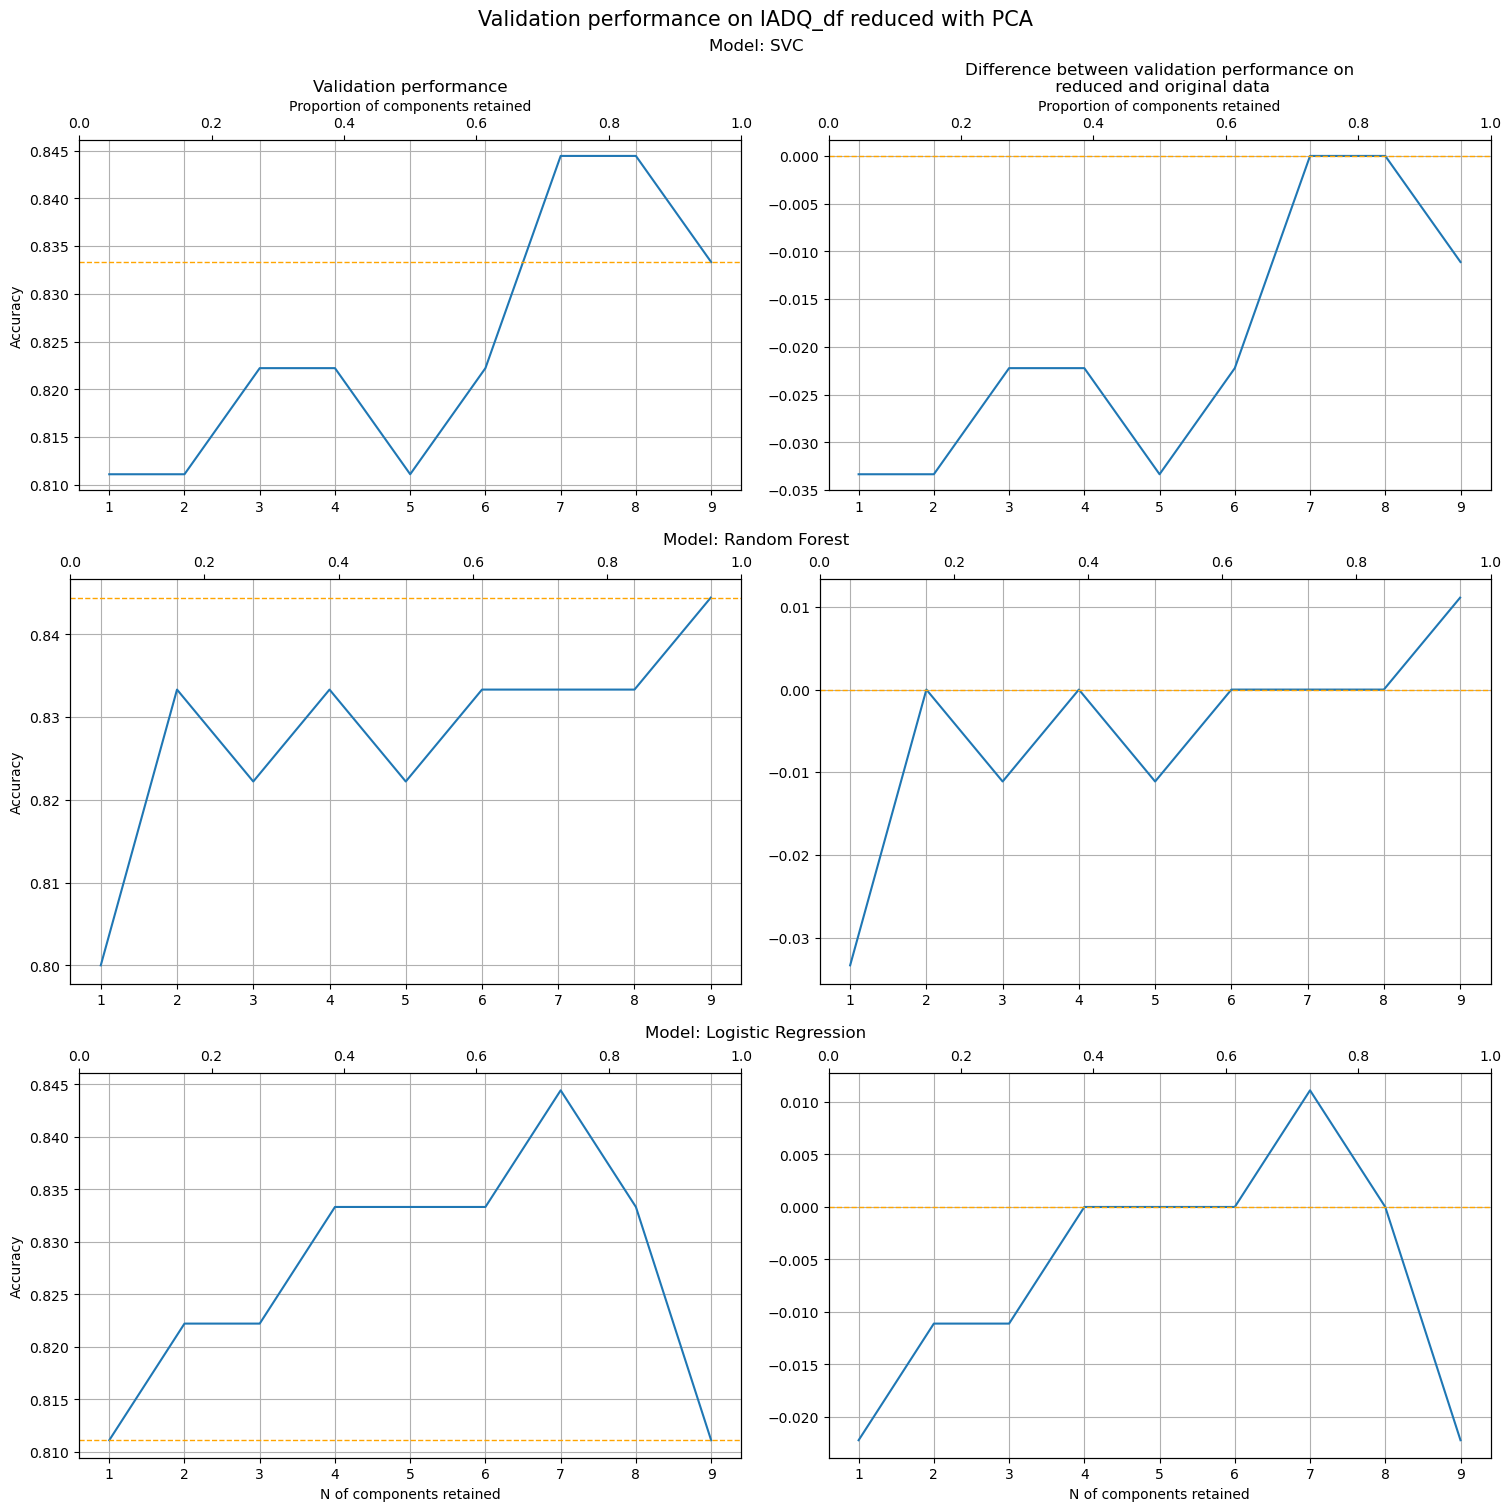

In [66]:
dname_expl = 'IADQ_df'
fname = 'PCA'
f = draw_dataset_scores(scores_pca[dname_expl], model_names, dname_expl, fname)
# f.savefig(fname=f'{dname}_{fname}_perf')

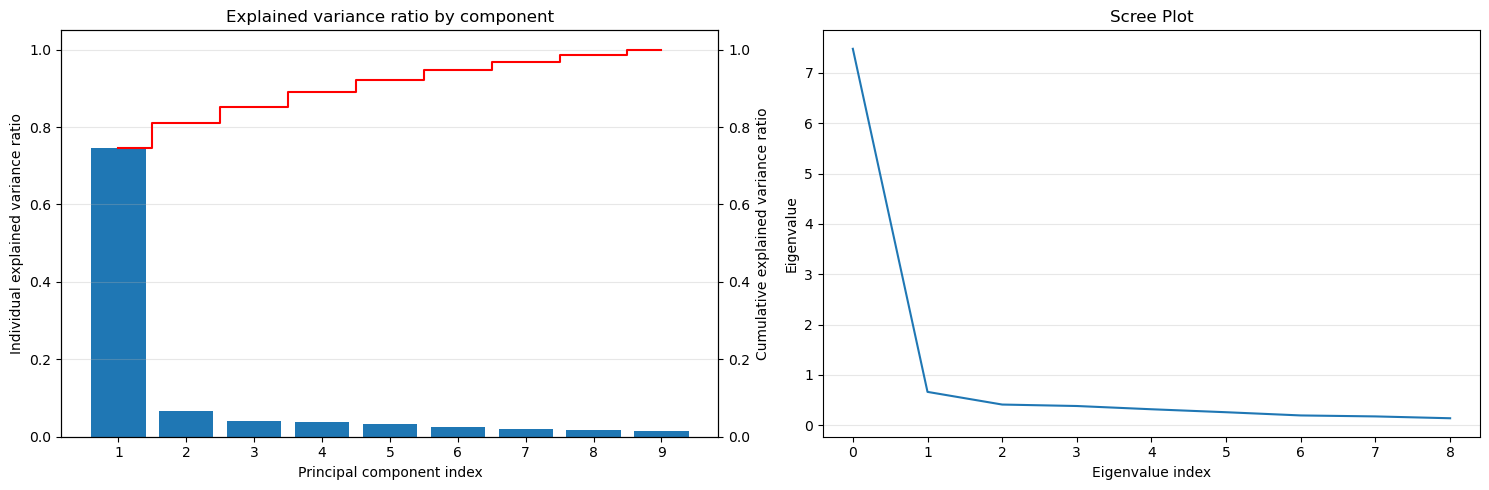

In [67]:
f = draw_pca_results(decomp[dname_expl])

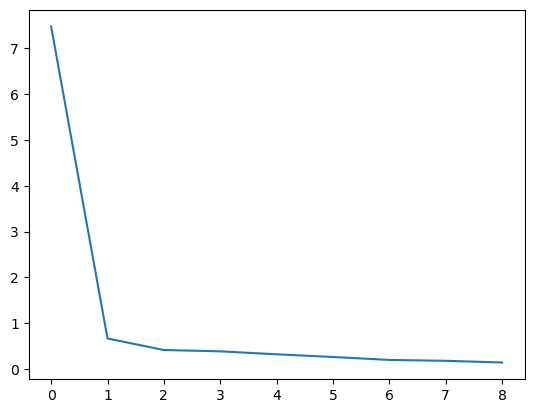

In [39]:
plt.plot(decomp[dname_expl].explained_variance_)

In [115]:
list(range(1,len(datasets[dname_expl].columns[:-1])+1))

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [150]:
d = preprocess(datasets[dname_expl], TARGET)
res = dict()
gs = dict()
for i in range(len(models)):
    pipe = Pipeline([('reduce',SelectKBest(chi2)),('model',clone(models[i]))])
    grid = {
        'reduce__k': range(1, len(datasets[dname_expl].columns[:-1]) + 1)
    }
    gridsearch = GridSearchCV(estimator=pipe, param_grid=grid, scoring='accuracy')
    gridsearch.fit(d['train'][0],d['train'][1])
    res[i] = gridsearch.cv_results_
    gs[i] = gridsearch

Factor Analysis

In [74]:
from sklearn.decomposition import FactorAnalysis
covars = dict()
fa_dict = dict()
for dname in list(datasets.keys()):
    d = preprocess(datasets[dname], TARGET)
    fa = FactorAnalysis(random_state=RANDOM_STATE)
    fa_dict[dname] = fa.fit(d['train'][0])
    covars[dname] = np.cov((d['train'][0] - d['train'][0].mean(axis=0)).T)

In [80]:
len(datasets[dname_expl].columns[:-1])

9

In [94]:
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

n_components = np.arange(1, len(datasets[dname_expl].columns[:-1]), 1)

def shrunk_cov_score(X):
    shrinkages = np.logspace(-2, 0, 30)
    cv = GridSearchCV(ShrunkCovariance(), {"shrinkage": shrinkages})
    return np.mean(cross_val_score(cv.fit(X).best_estimator_, X))

def compute_scores(X):
    pca = PCA(svd_solver="full")
    fa = FactorAnalysis()

    pca_scores, fa_scores = [], []
    for n in n_components:
        pca.n_components = n
        fa.n_components = n
        pca_scores.append(np.mean(cross_val_score(pca, X)))
        fa_scores.append(np.mean(cross_val_score(fa, X)))

    return pca_scores, fa_scores

d = preprocess(datasets[dname], TARGET)
pca_scores, fa_scores = compute_scores(d['train'][0])
n_components_pca = n_components[np.argmax(pca_scores)]
n_components_fa = n_components[np.argmax(fa_scores)]

In [95]:
n_components_pca

6

In [97]:
n_components_fa

2

Sparse PCA (PCA + Interpretability)

In [24]:
spca = SparsePCA(n_components=5,random_state=0)

# class model_evaluator:
#     def __init__(self, models):
#         self.models = models
    
#     def fit(self, X_train, y_train):
#         for model in self.models:
#             model.fit(X_train, y_train)

#     def score(self):
#         scores = model.score()
train, val, test = preprocess(datasets['PRMQ_df'], TARGET)
target_column_ind = datasets['PRMQ_df'].columns.get_loc(TARGET)
X_train, y_train = separate_target(train, target_column_ind)
X_val, y_val = separate_target(val, target_column_ind)
X_test, y_test = separate_target(test, target_column_ind)

# pipe = Pipeline([('SparcePCA', SparsePCA(n_components=5,random_state=0)), ])
spca.fit(X_train)
print(X_train.shape)
X_train_r = spca.transform(X_train)
spca.get_feature_names_out(input_features=datasets['PRMQ_df'].columns[:-1])

TypeError: string indices must be integers

OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD

In [ ]:
def build_feature_list(dname):
    return pd.DataFrame({'chi2': features_chi2[dname], 'mi': features_mi[dname], 'lasso': features_lasso[dname], 'f_score': features_f[dname]})

def build_binary_feature_table(dname, percentiles, feature_funs, full_feature_list):
    used_features = build_feature_list(dname)
    df = pd.DataFrame(index=pd.MultiIndex.from_product([percentiles, feature_funs]), columns=full_feature_list)
    for ftre in full_feature_list:
        for fun in feature_funs:
            for per in percentiles:
                if ftre in used_features[fun].loc[per]:
                    df[ftre].loc[(per,fun)] = 1
                else:
                    df[ftre].loc[(per,fun)] = 0
    return df

ft = build_binary_feature_table('IADQ_df', percentiles, feature_funs, np.arange(0,len(datasets['IADQ_df'].columns[:-1])))
prmq_cols = [col.replace('IADQ_df', '') for col in datasets['IADQ_df'].columns[:-1]]
ft.columns = prmq_cols
ft

Pr1 Pr2 Pr3 FA1 FA2 FA3 FI1 FI2 FI3
5   chi2      0   0   0   1   0   0   0   0   0
    mi        0   1   0   0   0   0   0   0   0
    lasso     0   0   0   0   0   0   0   0   1
    f_score   0   0   0   0   0   0   0   0   1
10  chi2      0   0   0   1   0   0   0   0   0
    mi        0   0   0   0   0   0   0   0   1
    lasso     0   0   0   0   0   0   0   0   1
    f_score   0   0   0   0   0   0   0   0   1
30  chi2      0   0   0   1   0   0   1   0   1
    mi        0   1   0   1   0   0   0   0   1
    lasso     0   1   0   0   1   0   0   0   1
    f_score   0   1   0   1   0   0   0   0   1
50  chi2      0   1   0   1   0   0   1   0   1
    mi        0   1   0   1   1   0   0   0   1
    lasso     0   1   0   1   1   0   0   0   1
    f_score   0   1   0   1   0   0   1   0   1
80  chi2      0   1   1   1   1   0   1   1   1
    mi        0   1   1   1   1   0   1   1   1
    lasso     1   1   1   1   1   0   1   0   1
    f_score   0   1   1   1   1   0   1   1   1
100 chi2      1   1   1   1   1   1   1   1   1
    mi        1   1   1   1   1   1   1   1   1
    lasso     1   1   1   1   1   1   1   1   1
    f_score   1   1   1   1   1   1   1   1   1

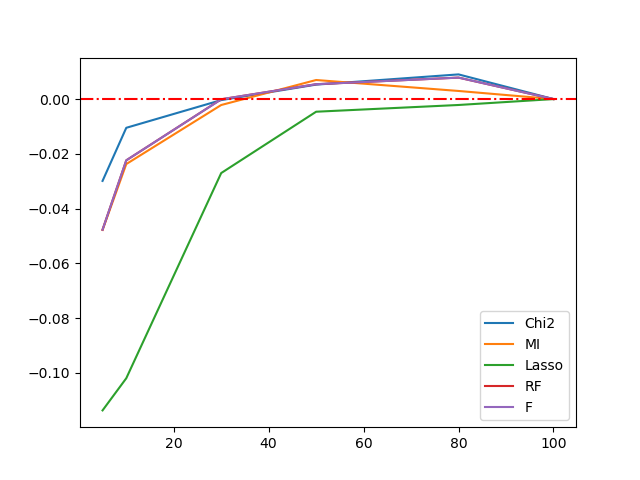

In [ ]:
scores_f_diff = scores_f.subtract(scores_f[100],axis='index')
scores_rf_diff = scores_rf.subtract(scores_rf[100],axis='index')

scores_chi2_avg = scores_chi2_diff.mean()
scores_mi_avg = scores_mi_diff.mean()
scores_f_avg = scores_f_diff.mean()
scores_lasso_avg = scores_lasso_diff.mean()
scores_rf_avg = scores_rf_diff.mean()
avg_scores = pd.DataFrame({"Chi2": scores_chi2_avg, "MI": scores_mi_avg, 'Lasso': scores_lasso_avg, 'RF': scores_rf_avg, 'F': scores_f_avg})
ax = plt.figure().add_subplot()
ax.plot(scores_chi2_avg.index, scores_chi2_avg)
ax.plot(scores_mi_avg.index, scores_mi_avg)
ax.plot(scores_lasso_avg.index, scores_lasso_avg)
ax.plot(scores_rf_avg.index, scores_rf_avg)
ax.plot(scores_f_avg.index, scores_rf_avg)
ax.axhline(y=0, linestyle='-.', c='red')
ax.legend(['Chi2', 'MI', 'Lasso', 'RF', 'F'])

Let's try adding a new feature: count of 5's in each row.

In [ ]:
expanded_datasets = dict()
for key in datasets.keys():
    expanded_datasets[key] = datasets[key].copy()
    expanded_datasets[key].insert(loc=0, column = 'NMAX', value = datasets[key][datasets[key] == datasets[key].max(axis=0)[:-1].max()].count(1))

In [ ]:
expanded_datasets['IADQ_df']

,NMAX,Pr1,Pr2,Pr3,FA1,FA2,FA3,FI1,FI2,FI3,CONDITION
0,1,4,2,3,2,2,2,2,2,1,H
1,0,2,3,2,3,2,1,3,2,3,H
2,4,4,3,3,4,4,4,3,3,3,H
3,0,3,3,2,1,3,2,3,2,3,H
4,1,3,2,2,3,3,3,4,3,3,H
...,...,...,...,...,...,...,...,...,...,...,...
445,9,4,4,4,4,4,4,4,4,4,D
446,6,4,3,4,4,3,3,4,4,4,D
447,6,3,4,4,4,4,4,3,3,4,D
448,3,3,4,4,3,3,3,3,4,3,D


In [ ]:
train_exp, val_exp, test_exp = preprocess(expanded_datasets['IADQ_df'], TARGET)

to_explore = expanded_datasets['IADQ_df']

target_column_ind = to_explore.columns.get_loc(TARGET)

X_train_exp, y_train_exp = separate_target(train, target_column_ind)
X_val_exp, y_val_exp = separate_target(val, target_column_ind)
X_test_exp, y_test_exp = separate_target(test, target_column_ind)
# check_split_integrity(rawdata, X_train, X_val, X_test)

C:\Users\xps\AppData\Local\Temp/ipykernel_7324/864869132.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(feature_names_in,rotation=45,ha='right')


<AxesSubplot:title={'center':'Feature importance with chi2'}, xlabel='features', ylabel='scores'>

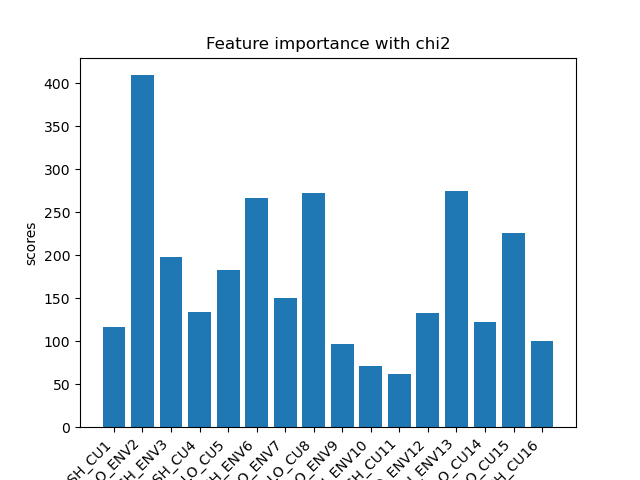

In [ ]:
plot_feature_importances(X_train, y_train, feature_names_in=rawdata.columns[:-1],score_func = chi2)

C:\Users\xps\AppData\Local\Temp/ipykernel_8912/864869132.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(feature_names_in,rotation=45,ha='right')


<AxesSubplot:title={'center':'Feature importance with mutual_info_classif'}, xlabel='features', ylabel='scores'>

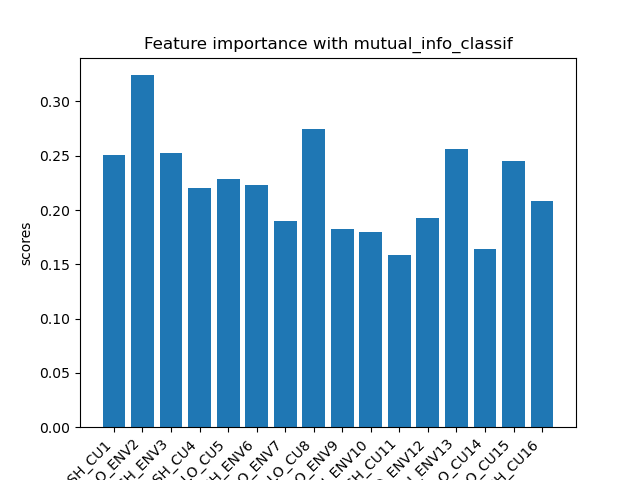

In [ ]:
plot_feature_importances(X_train, y_train, feature_names_in=rawdata.columns[:-1],score_func = mutual_info_classif)

C:\Users\xps\AppData\Local\Temp/ipykernel_8912/864869132.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(feature_names_in,rotation=45,ha='right')


<AxesSubplot:title={'center':'Feature importance with lasso_importance'}, xlabel='features', ylabel='scores'>

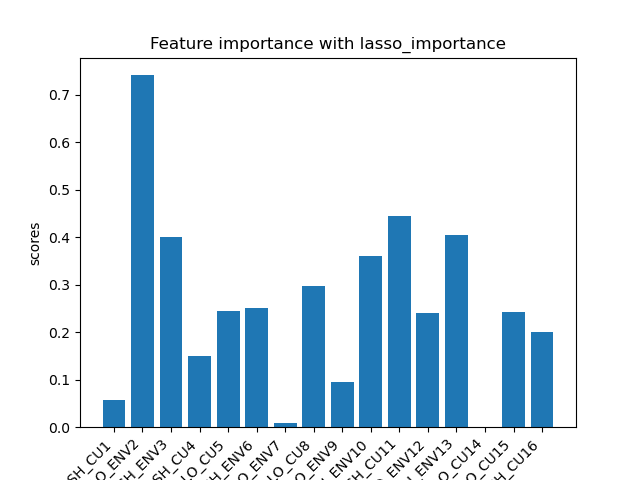

In [ ]:
plot_feature_importances(X_train, y_train, feature_names_in=rawdata.columns[:-1],score_func = lasso_importance)

C:\Users\xps\AppData\Local\Temp/ipykernel_8912/864869132.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(feature_names_in,rotation=45,ha='right')


<AxesSubplot:title={'center':'Feature importance with rf_importance'}, xlabel='features', ylabel='scores'>

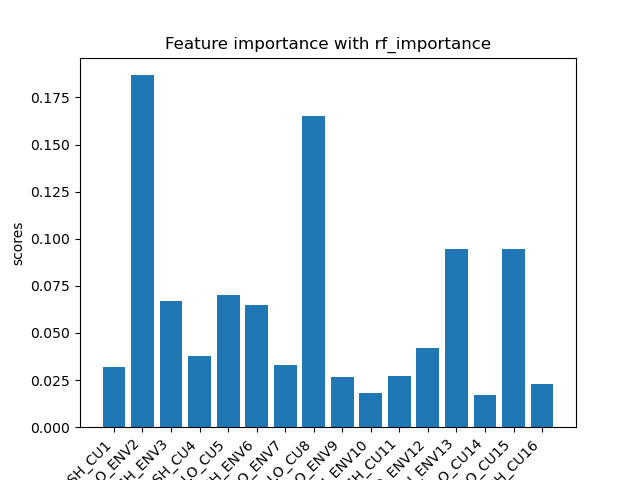

In [ ]:
plot_feature_importances(X_train, y_train, feature_names_in=rawdata.columns[:-1],score_func = rf_importance)

In [ ]:
exp_chi2_scores, exp_chi2_features = eval_for_all_datasets(expanded_datasets, models, model_names, feature_select_func=chi2)

OLD STUFF

In [ ]:
data_exp = add_interactions(rawdata, col_names=['Pr1', 'Pr2', 'Pr3'])
data_exp = add_interactions(data_exp, col_names=['FA1', 'FA2', 'FA3'])
data_exp = add_interactions(data_exp, col_names=['FI1', 'FI2', 'FI3'])

X_exp = data_exp.drop([TARGET],axis=1)
y_exp = data_exp[TARGET]

KeyError: 'Pr1'

In [ ]:
X_exp_train, X_exp_tv, y_exp_train, y_exp_tv = train_test_split(X_exp, y_exp, test_size=TESTSIZE,random_state=RANDOM_STATE)

sc_exp = StandardScaler()
X_exp_train = sc_exp.fit_transform(X_exp_train)
X_exp_tv = sc_exp.transform(X_exp_tv)

X_exp_val, X_exp_test, y_exp_val, y_exp_test = train_test_split(X_exp_tv, y_tv, test_size=VALSIZE,random_state=RANDOM_STATE)

NameError: name 'y_tv' is not defined

In [ ]:
np.sum(y_exp_train == 1)/np.sum(y_exp_train==0)

0.9444444444444444

In [ ]:
# lasso logistic model with no interactions
loglasso = sklearn.linear_model.LogisticRegressionCV(
    cv=5,
    random_state=RANDOM_STATE, 
    penalty='l1', 
    solver='liblinear',
    max_iter=1000
).fit(X_train, y_train)

loglasso.score(X_val, y_val)

0.8208955223880597

In [ ]:
loglasso.coef_

array([[ 0.34551073, -0.7710643 , -0.32557168, -0.77609551, -0.70529487,
         0.14356044, -0.23835024,  0.01854565, -0.53042108]])

In [ ]:
print(f'Used features:\n{data_exp.columns[loglasso.coef_.nonzero()[-1]].to_numpy()}')

Used features:
['Pr1' 'Pr2' 'Pr3' 'FA1' 'FA2' 'FA3' 'FI1' 'FI2' 'FI3']


In [ ]:
# lasso logistic model with interactions
loglasso_exp = sklearn.linear_model.LogisticRegressionCV(
    cv=5,
    random_state=RANDOM_STATE, 
    penalty='l1', 
    solver='liblinear',
    max_iter=10000
).fit(X_exp_train, y_exp_train)

loglasso_exp.score(X_exp_val, y_exp_val)

0.8208955223880597

In [ ]:
loglasso_exp.coef_

array([[ 0.39602845, -0.1284921 ,  0.        , -1.00973356, -0.20137843,
         0.5125152 , -0.14046987,  0.45907492,  0.        ,  0.        ,
         0.4720242 , -0.5441529 , -0.77596032,  0.        ,  0.22291391,
        -0.89326129,  0.        ,  0.        , -0.02781083, -0.46856733,
        -0.43026883]])

In [ ]:
print(f'Used features:\n{data_exp.columns[loglasso_exp.coef_.nonzero()[-1]].to_numpy()}')

Used features:
['Pr1' 'Pr2' 'FA1' 'FA2' 'FA3' 'FI1' 'FI2' 'Pr1.Pr2' 'Pr1.Pr3' 'Pr2.Pr3'
 'FA1.FA2' 'FA1.FA3' 'FI1.FI2' 'FI1.FI3' 'FI2.FI3']


In [ ]:
# ridge regression
logr = LogisticRegression(penalty='l2',random_state=RANDOM_STATE)
rfe = RFE(estimator=logr, n_features_to_select=5, step=1)
X_train_5 = rfe.fit_transform(X_train, y_train)

In [ ]:
X_val_5 = rfe.transform(X_val)
logr_5 = LogisticRegression(penalty='l2', random_state=RANDOM_STATE).fit(X_train_5, y_train)
logr_5.score(X_val_5, y_val)

0.8059701492537313

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [ ]:
random_forest_params =  {
        'n_estimators': [1, 2, 5, 10],
        'max_depth': [1, 2, 3],
        'random_state': [RANDOM_STATE],
    }
model = RandomForestClassifier()
random_forest = GridSearchCV(model, random_forest_params)
random_forest.fit(X_train, y_train)
random_forest.score(X_val, y_val)

0.8208955223880597